In [1]:
from utils import *
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
from scipy.spatial import distance 
import itertools

In [83]:
def sim_nback_context(set_size,nontarget_delta=-1,nitr=1,metric='cosine',cvar=.1,cmean=.1,cdim=20,verb=False):  
  exp_size = 5
  current_t = exp_size - 1
  target_t = current_t - set_size
  nontarget_t = target_t+nontarget_delta
  if verb:
    print('ss',set_size,'current_t',current_t,
          'target',target_t,'nontarget',nontarget_t)

  # loop vars
  dist2targetL = []
  dist2nontargetL = []
  for itr in range(nitr):
    C = fast_n_sphere(n_steps=exp_size, dim=cdim, var=cvar, mean=cmean)[0]
    # current_t,target_t,non_target_t
    dist2target_ = distance.cdist([C[current_t,:]],[C[target_t,:]],metric=metric)[0]
    dist2nontarget_ = distance.cdist([C[current_t,:]],[C[nontarget_t,:]],metric=metric)[0]
    dist2targetL.append(dist2target_)
    dist2nontargetL.append(dist2nontarget_)
    
  dist2target = np.concatenate(dist2targetL)
  dist2nontarget = np.concatenate(dist2nontargetL)
  return dist2target,dist2nontarget

dist2target,dist2nontarget = sim_nback_context(
  set_size=2,nitr=5,verb=True)
dist2target,dist2nontarget = sim_nback_context(
  set_size=3,nitr=10000,verb=True)



ss 2 current_t 4 target 2 nontarget 1
ss 3 current_t 4 target 1 nontarget 0


0.8937

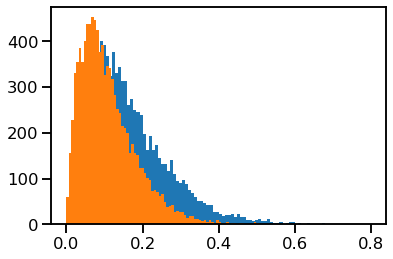

In [85]:
hist_nontarget = plt.hist(dist2nontarget,bins=100)[0]
hist_target = plt.hist(dist2target,bins=100)[0]

np.min([hist_target,hist_nontarget],axis=0).sum()/np.sum(hist_target)

In [3]:
def runexp_and_plt(M,N,K,ssL=[2,3],nitr=20000,sim_fn=sim_nback_context):
  """ 
  given parametrization of context
  runs 'dprime experiment' and generates plots
  """
  f,axarr = plt.subplots(1,3,figsize=(20,6))
  overlapL = []
  for idx,ss in enumerate(ssL):
    ax = axarr[idx]
    # run simulations
    dist2target,dist2nontarget = sim_fn(
      set_size=ss,nitr=nitr,metric='cosine',
      cvar=N,cmean=M,cdim=K
    ) 
    # calculate histogtams
    hist_target = ax.hist(dist2target,bins=int(nitr/100))[0]
    hist_nontarget = ax.hist(dist2nontarget,bins=int(nitr/100))[0]
    overlap = np.min([hist_target,hist_nontarget],axis=0).sum()/np.sum(hist_target)
    ax_title = 'ss=',ss,'overlap %.2f'%(overlap)
    ax.set_title(ax_title)
    overlapL.append(overlap)
  # calculate overlap difference
  axarr[2].bar(0,overlapL[1]-overlapL[0])
  axarr[2].set_ylim(-1,1)
  axarr[2].axhline(0,c='k')
  fig_title = "K{}M{}N{}".format(K,M,N)
  plt.savefig('figures/nback/%s.png'%fig_title)
  plt.close('all')
  return None

5 0.2 0.05


KeyboardInterrupt: 

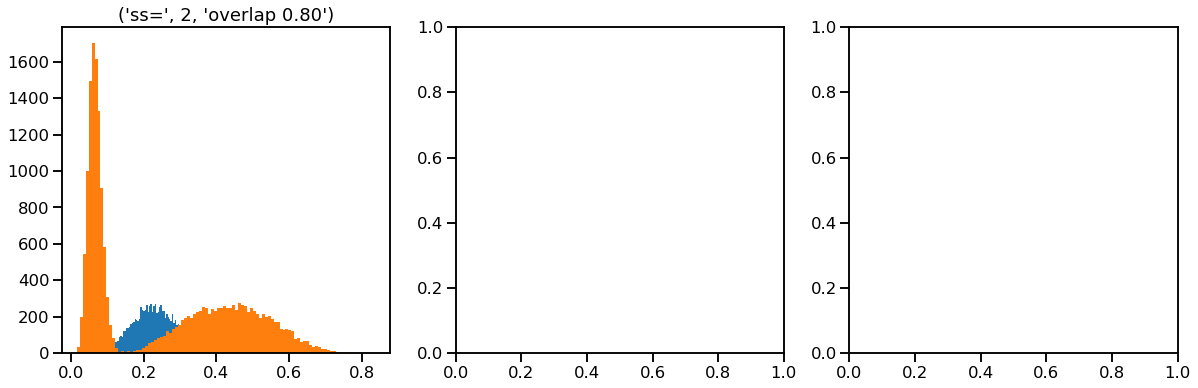

In [4]:
ML = [0.2,0.3,0.4]
NL = [0.05,0.1,0.2,0.3]
KL = [5,10,20,25] 
for K,M,N in itertools.product(KL,ML,NL):
  print(K,M,N)
  runexp_and_plt(M,N,K,nitr=10000)
  print()